In [6]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root

from matplotlib import rc
rc('text', usetex=True)

In [7]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [8]:
def getData(inputFiles):
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    scalar.append('quark_eta')
    scalar.append('quark_theta')
    scalar.append('quark_p')
    scalar.append('quark_pt')
    
    cols.append('n_total')
    cols.append('jet_eta')
    cols.append('jet_theta')
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('dphi_e_jet')
    cols.append('dR_q_jet')
    
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [9]:
#df = applyCut(df, 'e_pt>10 and e_pt<30', ' 10< e_pt<50')
def applyCuts(df):
    temp = df
    temp = applyCut(temp, '0.1 < y < 0.85', '0.1 < y < 0.85')
    temp = applyCut(temp, 'Q2>25', 'Q2>25')
    #temp = applyCut(temp, '0.1 < x < 0.7', '0.1 < x < 0.7')
    temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    temp.eval('dphi = 3.14159-dphi_e_jet', inplace=True)

    #df = applyCut(df, 'nconstituents>1', ' n>1')
    return temp

## Get data

In [19]:
df = getData(['pytree_10_275GeV_25GeV2.root'])
#df = getData(['pytree_10_275GeV_25GeV2.root'])
xsec = np.mean(df['xsec'])
ntrials = max(df['ntrials'])
accepted = df.shape[0]
ntrials = accepted
print 'xsec ' , xsec, ' ntrials', ntrials
print 'accepted ', df.shape[0]
df = applyCuts(df)



Processed pytree_10_275GeV_25GeV2.root in 2.4 seconds
xsec  1.7642578e-05  ntrials 217823
accepted  217823
0.1 < y < 0.85 125343  fraction kept: 57.5
Q2>25 124218  fraction kept: 99.1
dphi_e_jet>3.14159-0.4 52150  fraction kept: 42.0


## Plot cross-section

[2.19013654 2.66980635 3.25453039 3.96731699 4.83621358 5.89541039
 7.18658576]


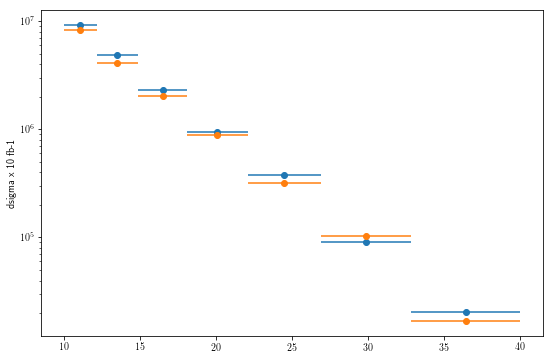

In [20]:
fig = plt.figure(figsize=(9,6))

#edges = np.logspace(0.69,1.6,11)

edges=np.logspace(np.log10(10),np.log10(40),nbins)

binwidth = (edges [1:] -  edges[:-1])
print binwidth

y, x  = np.histogram(df['e_pt'],bins=edges)
x = (x[1:]+x[:-1])/2

y = y*100*xsec*1e12/ntrials
erry = np.sqrt(y)
y = y/binwidth
erry = erry/binwidth

plt.errorbar(x,y=y , xerr=binwidth/2.0,yerr=erry, fmt='o',ls='none')
y, x  = np.histogram(df['jet_pt'],edges)
x = (x[1:]+x[:-1])/2
y = y*100*xsec*1e12/ntrials
erry = np.sqrt(y)

y = y/binwidth
erry = erry/binwidth

plt.errorbar(x,y=y , xerr=binwidth/2.0, yerr=erry, fmt='o',ls='none')

plt.ylabel('dsigma x 10 fb-1')
plt.yscale('log')
plt.show()


## Factors for statistical projection

In [21]:
dilution_factor =0.7 # proton polarization for single-spin asymmetries ()
efficiency = 0.5 #efficiency
penalty = 1.0 #sqrt(2) coming from separating Sivers v Collins v something else
lumi = 100 # in units of fb-1. 100 is expected in a year? (check)

label = "$e+p^{\uparrow}$, 10+100 GeV, 100 fb$^{-1}$ \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$"

## Sivers asymmetry (phi) for various electron pT

6.8500195  mean pt
0.027369706
70.41933  mean Q2
 
9.887229  mean pt
0.056295145
146.30745  mean Q2
 
14.683161  mean pt
0.12297524
329.56577  mean Q2
 


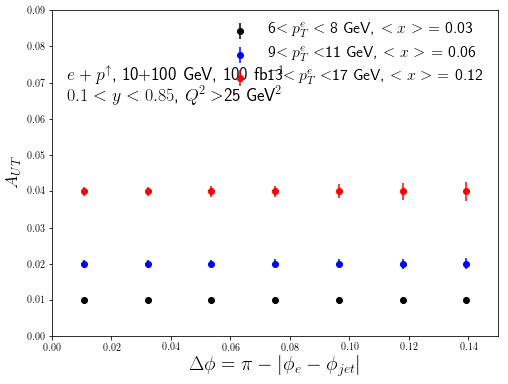

In [22]:
def fake_A(x,slope=0.05):
    return slope*np.ones(len(x))

fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04,0.06]
colores = ['black','blue','red','purple']
for counter,edges in enumerate([(6.0,8.0), (9,11),(13.0,17.0)]):
    maxdphi = 0.15
    df_cut = df.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    mean_x = df_cut['x'].mean()
    print mean_x
    
    print df_cut['Q2'].mean(), ' mean Q2'

    y, x  = np.histogram(df_cut['dphi'],bins=7,range=(0.0,maxdphi))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec*1e12/ntrials ##total number of counts
    y = y*efficiency # take efficiency hit
    erry = 1/(dilution_factor*np.sqrt(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none', color=colores[counter],label='%2.0f$<p_{T}^{e}<$%2.0f GeV, $<x>$ = %2.2f'%(edges[0],edges[1],mean_x))
    print ' '
####
plt.legend(frameon=False,loc='best',ncol=2,fontsize=16)
plt.ylim([0.0,0.09])
#plt.ylim([-0.15,0.15])

plt.xlim([0.0,0.15])

plt.text(0.005, 0.065, label, fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers.png', bbox_inches='tight')
plt.savefig('AUT_Sivers.pdf', bbox_inches='tight')

## Sivers vs x 

10.567941  mean pt
0.068172015  mean x
171.53067  mean Q2
 
16.661135  mean pt
0.17099918  mean x
418.76172  mean Q2
 
20.115715  mean pt
0.24019134  mean x
632.5541  mean Q2
 
25.07397  mean pt
0.39864126  mean x
991.29846  mean Q2
 


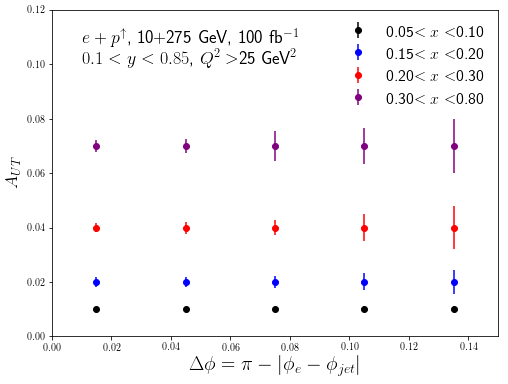

In [23]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04,0.07]
colores = ['black','blue','red','purple']
for counter,edges in enumerate([(0.05,0.1), (0.15,0.2),(0.2,0.3),(0.3,0.8)]):
    maxdphi = 0.15
    df_cut = df.query('x > %2.2f and x<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    print df_cut['x'].mean(), ' mean x'
    print df_cut['Q2'].mean(), ' mean Q2'

    y, x  = np.histogram(df_cut['dphi'],bins=5,range=(0.0,maxdphi))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec*1e12/ntrials ##total number of counts
    y = y*efficiency # take efficiency hit
    erry = 1/(dilution_factor*np.sqrt(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',color=colores[counter],label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
    print ' '
####
plt.ylim([0.0,0.12])
plt.xlim([0.0,0.15])

plt.text(0.01, 0.1, '$e+p^{\uparrow}$, 10+275 GeV, 100 fb$^{-1}$ \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False,ncol=1)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers_xbins.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_xbins.pdf', bbox_inches='tight')

## Sivers(x) for various Q2 bins

6.594046  mean pt
0.030289467  mean x
85.491776  mean Q2


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


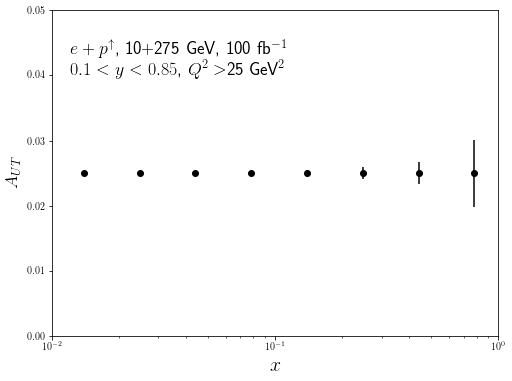

In [24]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.025]
colores = ['black','blue','red','purple']


for counter,edges in enumerate([(25,200000)]):
    df_cut = df.query('Q2 > %2.2f and Q2<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    print df_cut['x'].mean(), ' mean x'
    print df_cut['Q2'].mean(), ' mean Q2'
    y, x  = np.histogram(df_cut['x'],bins=np.logspace(-2,0.0,9))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec*1e12/ntrials ##total number of counts
    y = y*efficiency # take efficiency hit
    erry = 1/(dilution_factor*np.sqrt(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',color=colores[counter])
    #plt.errorbar(x,y,label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
####
plt.ylim([0.0,0.05])
plt.xlim([0.01,1.0])
#plt.yscale('log')

plt.xscale('log')
plt.text(0.012, 0.04, '$e+p^{\uparrow}$, 10+275 GeV, 100 fb$^{-1}$ \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False,ncol=1)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$x$',fontsize=20)
plt.savefig('AUT_Sivers_xdependence.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_xdependence.pdf', bbox_inches='tight')

## Distributions

6.8500195  mean pt
9.887229  mean pt
14.683161  mean pt


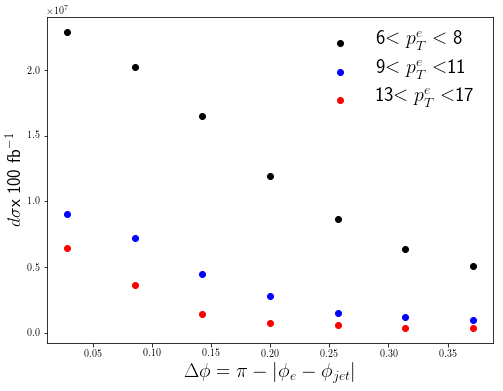

In [25]:

fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04]
colores = ['black','blue','red']
for counter,edges in enumerate([(6.0,8.0), (9,11),(13.0,17.0)]):
    maxdphi = np.pi
    df_cut = df.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    y, x  = np.histogram(df_cut['dphi'],bins=7,range=(0.0,0.4))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec*1e12/ntrials
    erry = np.sqrt(y)
    plt.errorbar(x,y ,fmt='o',ls='none',color=colores[counter],label='%2.0f$<p_{T}^{e}<$%2.0f'%(edges[0],edges[1]))

####
plt.legend(frameon=False,loc='best')
#plt.ylim([0.0,0.07])

#plt.text(0.01, 0.05, '$e+p^{\uparrow}$, 18+100 GeV \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$\n 100 fb$^{-1}$', fontsize=18)
plt.legend(loc='best', fontsize=20,frameon=False)
plt.ylabel('$d\sigma $x 100 fb$^{-1}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers_distributions.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_distributions.pdf', bbox_inches='tight')